<a href="https://colab.research.google.com/github/J0han-ai/fast.ai/blob/main/vgg16bn_early_stopping_Albumentations_2_likeDeepFake_FastAI_xray_f1Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#для kaggle 
#!pip install --user ../input/fastaimaster/torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -U fastai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.4.5 installed.
fastai version 2.7.6 installed.


In [ ]:
#Когда будем юзать fastai2.medical.imaging , пока не используется
#!pip install pydicom kornia opencv-python scikit-image

In [3]:
import pandas as pd
%matplotlib inline

In [ ]:
#!pip install --no-cache-dir -I pillow
#еще один костыль.Если  ругается,типа AttributeError: module 'PIL.Image' has no attribute 'Resampling',раскомментировать и выполнить один раз

In [4]:
from fastai import *
from fastai.vision.all import *



In [ ]:
#!pip uninstall opencv-python-headless==4.5.5.62

In [5]:
!pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 12.7 MB/s 


In [6]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ojdxoxy8
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ojdxoxy8
  Created wheel for albumentations: filename=albumentations-1.2.1-py3-none-any.whl size=116663 sha256=51e41cfdd3ee76a3da685cd486d67e144b05cf9b548359365712eddaa9a9c27c
  Stored in directory: /tmp/pip-ephem-wheel-cache-nku028qz/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [7]:
#!Albumentations.Мегакрутая вещь!
# Начало albumentations


import albumentations as Alb
import cv2


class AlbTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_augs(): return  Alb.Compose([
    Alb.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
    Alb.GaussNoise(p=0.1),
    Alb.GaussianBlur(blur_limit=3, p=0.05),
    Alb.HorizontalFlip(),

    Alb.RandomBrightnessContrast(),
    Alb.OneOf([Alb.RandomBrightnessContrast(), Alb.FancyPCA(), Alb.HueSaturationValue()], p=0.7),
    #Alb.PadIfNeeded(),Сильно меняет изображение, попробовать отдельно c ним
    Alb.ToGray(p=0.2), 
    Alb.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5),
                                     ])  
  
    
#Надо посмотреть, что еще можно подобрать, исходя из условий задачи.
#статьи по подбору аугментации в мед процессинге
#https://arxiv.org/pdf/2010.11695.pdf
#https://arxiv.org/pdf/2003.04696v5.pdf




In [8]:
item_tfms = [Resize(224), AlbTransform(get_augs())]
batch_tfms = Normalize.from_stats(*imagenet_stats) 

# Конец albumentations

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1766: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
train_path='/content/drive/MyDrive/train_xray/train_xray'
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')[['SOPInstanceUID', 'Target']]
train_df['Target'] = train_df['Target'].apply(lambda x: x.strip())





In [11]:
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2


In [12]:
dls = ImageDataLoaders.from_df(train_df,
                               path=train_path, 
                               suff='-c.bone.jpg',
                               item_tfms=item_tfms,
                               batch_tfms=batch_tfms, 
                               shuffle=True, 
                               bs=64, 
                               valid_pct=0.2,
                               label_delim=' ',# !важно! - предупреждаем нейросеть,что у нас есть некоторая multi-label problem
                                               # без этого будет вываливаться ошибка при обучении cnn
                               num_workers = 0, #Чтобы не переполнялась память при обучении
                               )

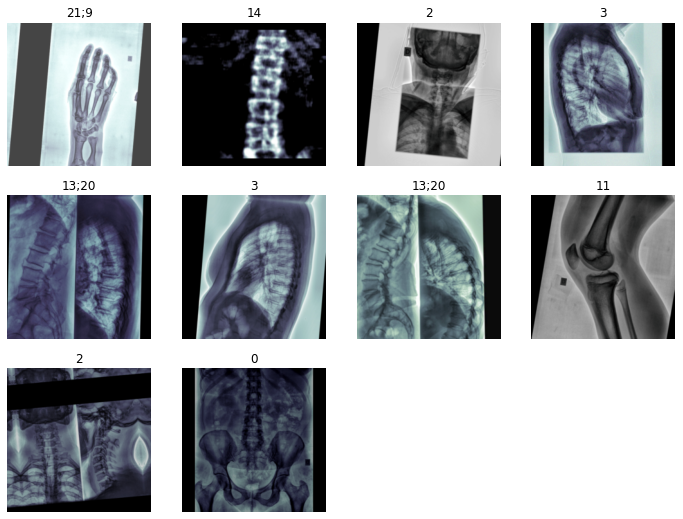

In [13]:
dls.train.show_batch(max_n=10)


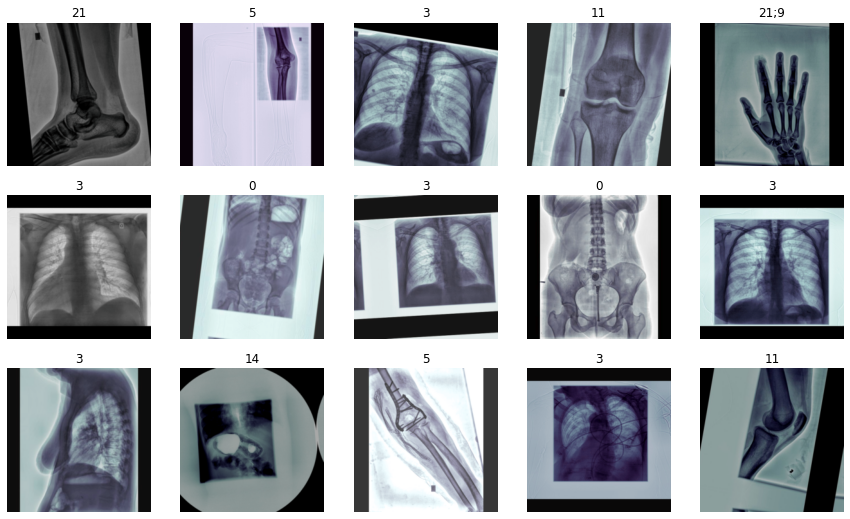

In [ ]:
dls.valid.show_batch(max_n=15)

In [14]:
#Чтобы корректно считалась метрика F1Score, взял с public kernel этого Kaggle-соревнования.
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_micro = F1ScoreMulti(thresh=0.5, average='micro')
f1_weighted = F1ScoreMulti(thresh=0.5, average='weighted')



In [15]:
learn = vision_learner(dls,vgg16_bn, 
                    #loss_func=  BaseLoss,
                    metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples, f1_micro, f1_weighted]
                      )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

CPU times: user 4min 32s, sys: 11.7 s, total: 4min 44s
Wall time: 18min 20s


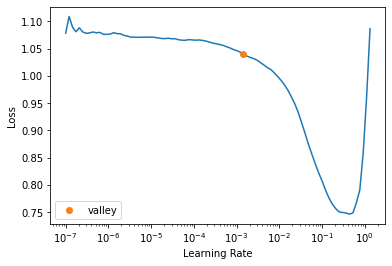

In [16]:
%%time
lr = learn.lr_find()

In [ ]:
#155

In [17]:
%%time
learn.fine_tune(100,1e-3,cbs=[EarlyStoppingCallback(patience=8)]
                #lr[0]
                )

epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,1.023840,0.697852,0.566020,0.128800,0.151005,0.148110,0.440569,04:45


epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.934928,0.697731,0.578858,0.144821,0.167698,0.162106,0.469086,01:15
1,0.921882,0.715804,0.569557,0.138936,0.170282,0.165142,0.462401,01:15
2,0.912865,0.696746,0.589730,0.149199,0.181915,0.174486,0.470814,01:17
3,0.894973,0.681999,0.600603,0.152852,0.191627,0.181916,0.482554,01:15
4,0.881279,0.666444,0.605973,0.156911,0.191814,0.184824,0.489131,01:15
5,0.866635,0.659334,0.618287,0.163692,0.199394,0.191005,0.498521,01:15
6,0.852042,0.639910,0.631648,0.166340,0.206488,0.197489,0.509042,01:14
7,0.835257,0.630862,0.648808,0.171519,0.216647,0.205630,0.505319,01:15
8,0.815529,0.613724,0.660990,0.174731,0.226218,0.210012,0.508973,01:14
9,0.796833,0.586083,0.686141,0.186250,0.245909,0.226098,0.521844,01:14


No improvement since epoch 50: early stopping
CPU times: user 1h 16min 33s, sys: 2min 30s, total: 1h 19min 4s
Wall time: 1h 18min 19s


In [ ]:
#Predictions to csv

In [ ]:
#!zip -r test.zip /content/drive/MyDrive/xr/xray/test

In [ ]:
#!unzip -j /content/test.zip -d /content/drive/MyDrive/test

In [ ]:
test_df = pd.read_csv ('/content/drive/MyDrive/sample_submission.csv')
# pd.read_csv ('/content/submit.csv')
#pd.read_csv ('/content/drive/MyDrive/xr/xray/sample_submission.csv')
test_path= ('/content/drive/MyDrive/test_xray')

In [ ]:
test_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542754353271306894106,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
1,1.2.826.0.1.3680043.8.498.10022667601042710442884728915610557590,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
2,1.2.826.0.1.3680043.8.498.10024395388921105474336784272390605225,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
3,1.2.826.0.1.3680043.8.498.10026689165626095651568657562992631805,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
4,1.2.826.0.1.3680043.8.498.10035936364561920980924160549027696414,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746555980174715994054,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
739,1.2.826.0.1.3680043.8.498.99120415799121180043999929775380253296,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
740,1.2.826.0.1.3680043.8.498.99132008951330408682785705454375383148,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
741,1.2.826.0.1.3680043.8.498.99611256581875030709909119881605604054,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21


In [ ]:
tdls = ImageDataLoaders.from_df(test_df, path=test_path, suff='-c.bone.jpg',
   item_tfms=item_tfms, batch_tfms=batch_tfms, shuffle=False)
tst_dl = tdls.test_dl(test_df) 

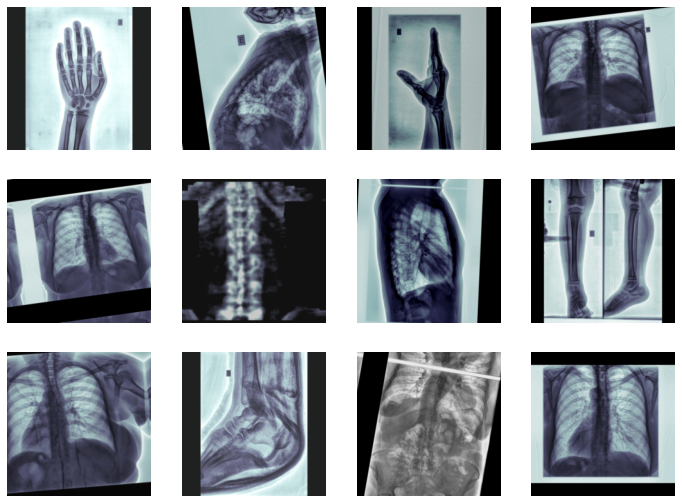

In [ ]:
tst_dl.show_batch(max_n=12)

In [ ]:
%%time
preds = learn.tta(dl=tst_dl, n=64, use_max=False)
#preds = learn.get_preds(dl=tst_dl, n=64, use_max=False)
#preds = learn.get_preds(dl=tst_dl)
#preds = learn.get_preds

CPU times: user 3min 53s, sys: 8.22 s, total: 4min 2s
Wall time: 24min 20s


In [ ]:
#!pip uninstall nbdev.
#!pip install nbdev

In [ ]:
predss = learn.dls.vocab[np.argmax(preds[0], axis=1)]

In [ ]:
test_df['Target'] = predss

In [ ]:
submission_df = test_df[['SOPInstanceUID', 'Target']]

In [ ]:
submission_df.to_csv(f'Goooodboy.csv', header=True, index=False)

In [ ]:
submission_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542754353271306894106,9
1,1.2.826.0.1.3680043.8.498.10022667601042710442884728915610557590,3
2,1.2.826.0.1.3680043.8.498.10024395388921105474336784272390605225,9
3,1.2.826.0.1.3680043.8.498.10026689165626095651568657562992631805,3
4,1.2.826.0.1.3680043.8.498.10035936364561920980924160549027696414,3
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746555980174715994054,3
739,1.2.826.0.1.3680043.8.498.99120415799121180043999929775380253296,3
740,1.2.826.0.1.3680043.8.498.99132008951330408682785705454375383148,3
741,1.2.826.0.1.3680043.8.498.99611256581875030709909119881605604054,21


In [ ]:
test_df.Target.value_counts()

3     341
14     56
6      48
0      42
11     38
21     29
13     28
9      27
15     22
1      21
2      17
16     15
5      12
20     11
12      8
7       6
10      6
17      4
4       4
19      3
18      3
8       2
Name: Target, dtype: int64

AttributeError: 'dict' object has no attribute ..

'When you bring your learner back in make sure to re-define any functions your model wants to use along with it' - нифига, проще заново загрузить
